# Clustering Analysis

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from statsmodels.stats.oneway import anova_oneway

## Load and Preprocess Data

In [22]:
feature_data = pd.read_csv('feature_data_filtered.csv')

In [23]:
# Drop noisy features, I planned on including them in the clustering but they didn't add much value and made the clusters less interpretable
cluster_data = feature_data.drop(columns=['Name', 'C&S_Guarded_prop', 'Length'])
cluster_features = cluster_data.columns

In [24]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

## Akaike Information Criterion (AIC)

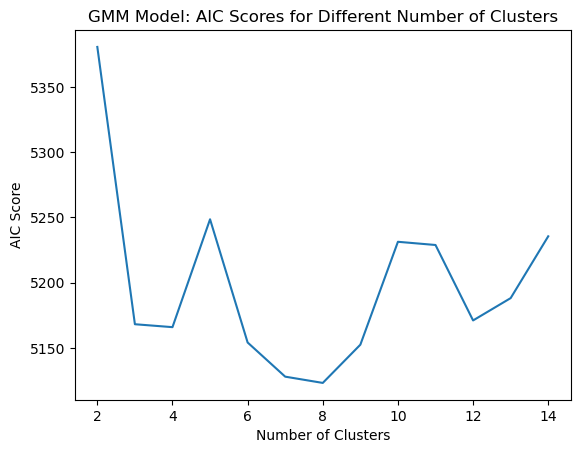

In [25]:
# Plot the AIC for a range of number of clusters to find the optimal number of clusters
n_clusters = range(2, 15)
aic_scores = []

for k in n_clusters:
    gmm_k = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_k.fit(X_scaled)
    aic_scores.append(gmm_k.aic(X_scaled))


plt.plot(n_clusters, aic_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')
plt.title('GMM Model: AIC Scores for Different Number of Clusters')
plt.show()

## Initialize and Fit the GMM

In [26]:
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

cluster_labels = gmm.predict(X_scaled)


df_clustered = cluster_data.copy()
df_clustered['Cluster'] = cluster_labels

In [27]:
centroid_z_scores = pd.DataFrame(gmm.means_, columns=cluster_features)
centroid_z_scores['Cluster'] = range(8)
centroid_z_scores.set_index('Cluster', inplace=True)

## Centroid Analysis

Plot the centroids of each cluster in the form of a heatmap and line graph. The goal here is to ensure that the centroids are distinct and meaningful.

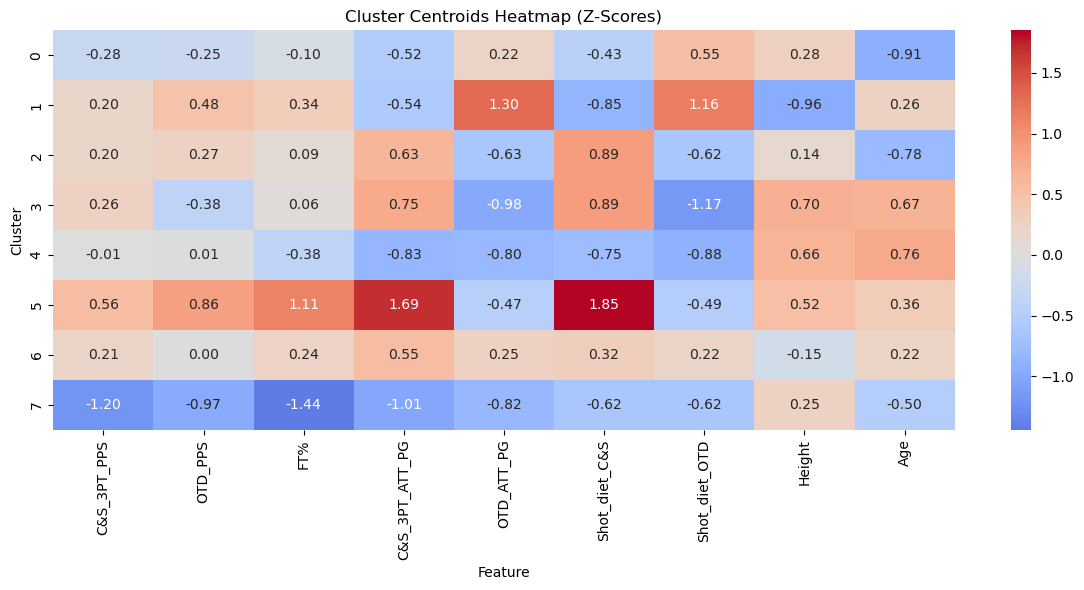

In [28]:
# Heatmap of cluster centroids
plt.figure(figsize=(12,6))
sns.heatmap(centroid_z_scores, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Cluster Centroids Heatmap (Z-Scores)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

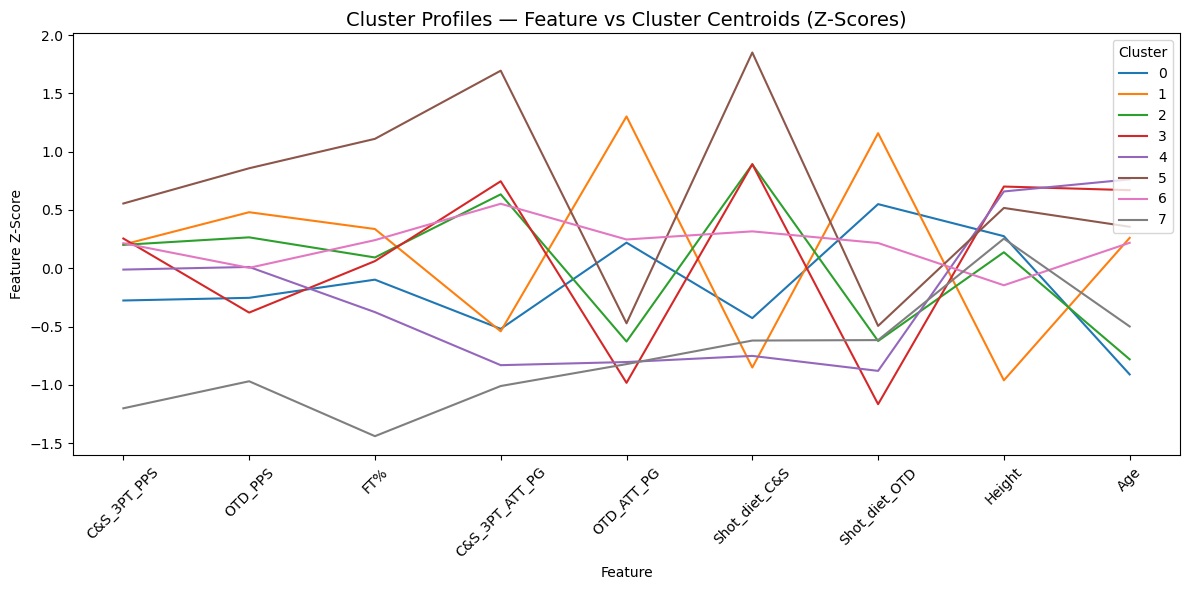

In [29]:
# Loop through each cluster and plot the z-scores for each feature
plt.figure(figsize=(12,6))

for cluster in centroid_z_scores.index:
    plt.plot(centroid_z_scores.columns, centroid_z_scores.loc[cluster], label = cluster)

plt.xticks(rotation=45)
plt.ylabel('Feature Z-Score')
plt.xlabel('Feature')
plt.title('Cluster Profiles — Feature vs Cluster Centroids (Z-Scores)', fontsize=14)
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

## Archetype Labeling

Based on centroid data and manually looking at the players in each cluster, we can label the archetypes

In [30]:
# Add names back to the cluster dataframe and z-score cluster dataframe
full_df = feature_data[['Name']].merge(df_clustered, left_index=True, right_index=True, how='left')

X_scaled_df = pd.DataFrame(X_scaled, columns=cluster_features)
X_scaled_df["Cluster"] = cluster_labels
full_z_df = feature_data[['Name']].merge(X_scaled_df, left_index=True, right_index=True, how='left')

In [31]:
shooting_archetypes = {
    0: 'Young, Unproven Shooter', # Players like 
    1: 'High-Volume, Off the Dribble Guard', # Players like 
    2: 'Young, Efficient, Catch-and-Shoot Heavy', # Players like 
    3: 'Solid Catch-and-Shoot Only Veteran Forward', # Players like 
    4: 'Average Efficiency, Low Volume Forward', # Players like
    5: 'Elite Efficiency, Catch-and-Shoot Specialist', # Players like
    6: 'High Volume, Efficient, Balanced Shooter', # Players like
    7: 'Poor All Around Shooter' # Players like
}

In [32]:
centroid_z_archetypes = centroid_z_scores.copy()
centroid_z_archetypes['Archetype'] = centroid_z_archetypes.index.map(shooting_archetypes)
centroid_z_archetypes.set_index('Archetype', inplace=True)

In [33]:
full_df['Archetype'] = full_df['Cluster'].map(shooting_archetypes)

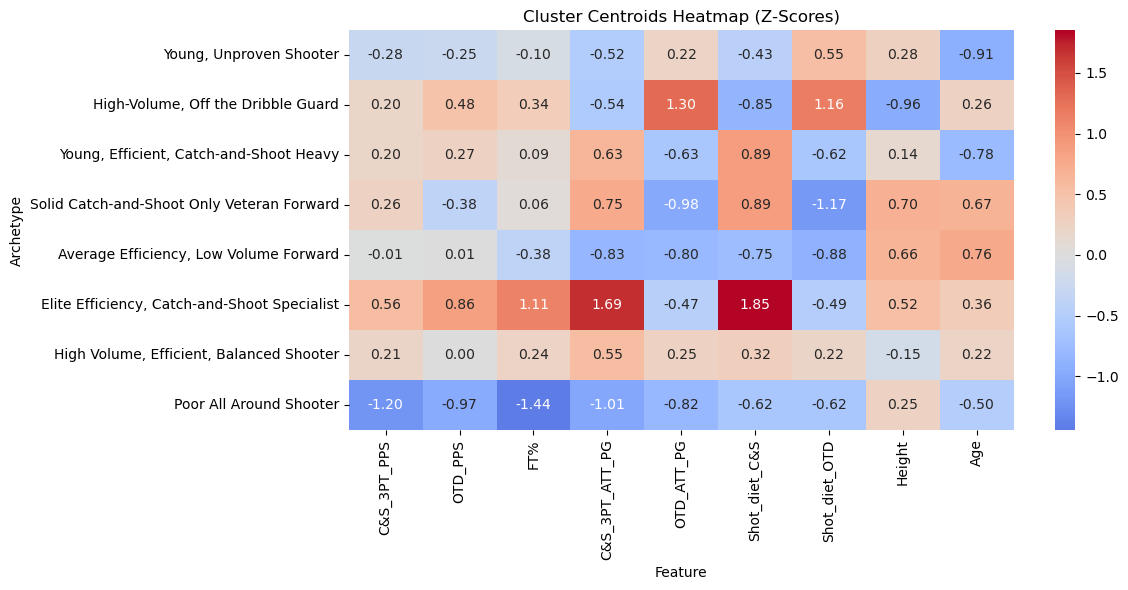

In [34]:
# Replot the heatmap with archetype labels
plt.figure(figsize=(12,6))
sns.heatmap(centroid_z_archetypes, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Cluster Centroids Heatmap (Z-Scores)")
plt.ylabel("Archetype")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Exploring NBA Success by Archetype

In [35]:
# Load NBA outcome data
nba_otd = pd.read_csv('otd_target_data.csv')
nba_cas = pd.read_csv('cas_target_data.csv')

In [36]:
full_df_nba = full_df.merge(nba_otd, left_on='Name', right_on='Player', how='left')
full_df_nba = full_df_nba.merge(nba_cas, left_on='Name', right_on='Player', how='left')
full_df_nba.rename(columns={'NBA_C&S_PPS': 'NBA_CAS_PPS'}, inplace=True)

## Visualizing NBA Shooting Success

### Catch and Shoot Success Distributions for each archetype

Text(0.5, 1.0, 'NBA Catch-and-Shoot Points Per Shot by College Archetype')

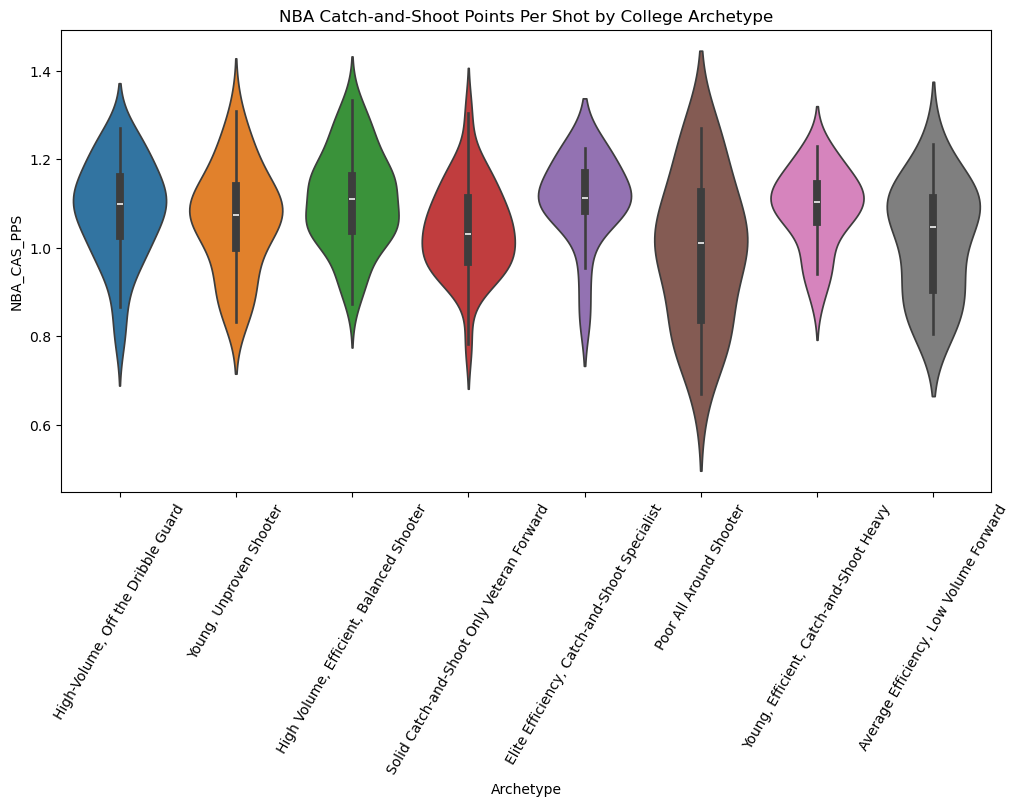

In [37]:
plt.figure(figsize=(12,6))
sns.violinplot(data=full_df_nba, x='Archetype', y='NBA_CAS_PPS', hue='Archetype')
plt.xticks(rotation=60)
plt.title('NBA Catch-and-Shoot Points Per Shot by College Archetype')

### Off the Dribble Success Distributions for each archetype

Text(0.5, 1.0, 'NBA Off-the-Dribble Points Per Shot by College Archetype')

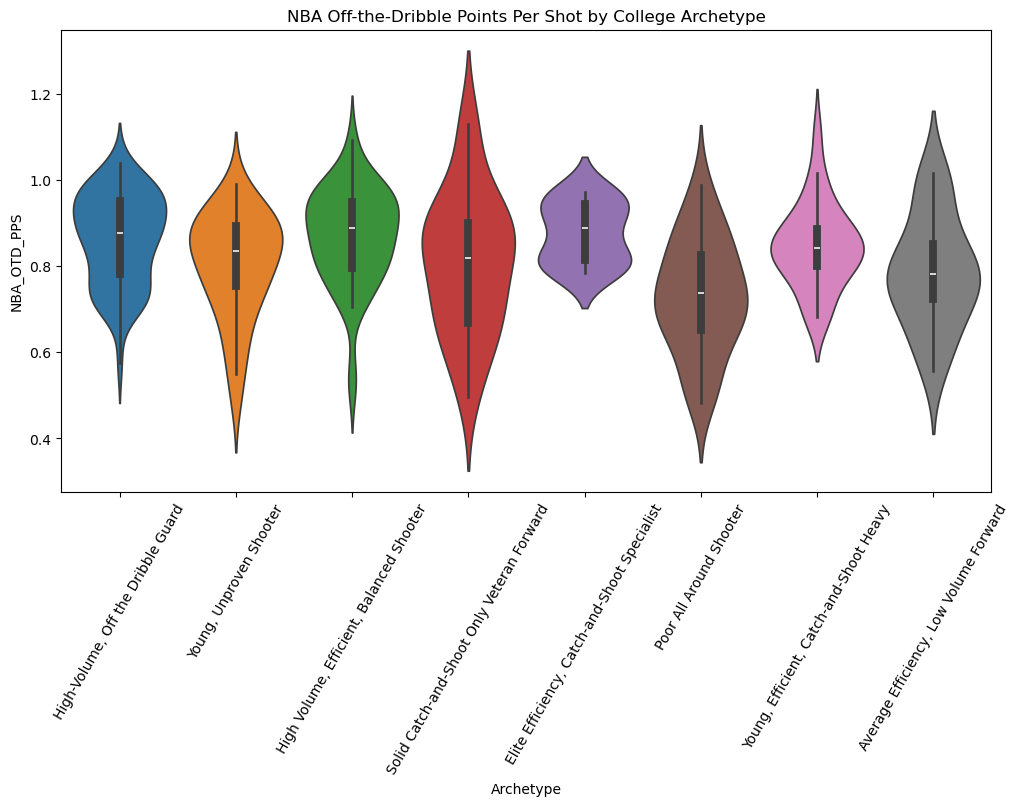

In [38]:
plt.figure(figsize=(12,6))
sns.violinplot(data=full_df_nba, x='Archetype', y='NBA_OTD_PPS', hue='Archetype')
plt.xticks(rotation=60)
plt.title('NBA Off-the-Dribble Points Per Shot by College Archetype')

## Statistical Tests

In [39]:
OTD_ANOVA_df = full_df_nba[['Archetype', 'NBA_OTD_PPS']].dropna()

welch_result = anova_oneway(OTD_ANOVA_df['NBA_OTD_PPS'], groups=OTD_ANOVA_df['Archetype'], use_var='unequal')

print(welch_result)

statistic = 4.874423499401853
pvalue = 0.00012233783868034295
df = (7.0, 82.73376883251531)
df_num = 7.0
df_denom = 82.73376883251531
nobs_t = 257.0
n_groups = 8
means = [0.78570874 0.87625552 0.86986194 0.86346086 0.73115048 0.8081836
     0.84619619 0.8011302 ]
nobs = [18. 15. 53. 60. 26. 25. 27. 33.]
vars_ = [0.01669071 0.00500918 0.01274888 0.01111593 0.01750887 0.02635359
     0.00972209 0.01471305]
use_var = unequal
welch_correction = True
tuple = (4.874423499401853, 0.00012233783868034295)


In [40]:
# If not installed:
# pip install pingouin

import pingouin as pg

# Drop missing values
df_posthoc = full_df_nba[['Cluster', 'NBA_OTD_PPS']].dropna()

# Run Games–Howell
gh = pg.pairwise_gameshowell(
    data=df_posthoc,
    dv='NBA_OTD_PPS',
    between='Cluster'
)

print(gh)

    A  B   mean(A)   mean(B)      diff        se         T          df  \
0   0  1  0.801130  0.863461 -0.062331  0.025122 -2.481117   58.628872   
1   0  2  0.801130  0.846196 -0.045066  0.028389 -1.587453   57.999480   
2   0  3  0.801130  0.808184 -0.007053  0.038730 -0.182118   42.846395   
3   0  4  0.801130  0.785709  0.015421  0.037056  0.416172   33.200578   
4   0  5  0.801130  0.876256 -0.075125  0.027925 -2.690271   42.890176   
5   0  6  0.801130  0.869862 -0.068732  0.026199 -2.623435   64.322055   
6   0  7  0.801130  0.731150  0.069980  0.033455  2.091728   51.444673   
7   1  2  0.863461  0.846196  0.017265  0.023353  0.739305   53.407253   
8   1  3  0.863461  0.808184  0.055277  0.035205  1.570143   32.765611   
9   1  4  0.863461  0.785709  0.077752  0.033355  2.331079   24.193500   
10  1  5  0.863461  0.876256 -0.012795  0.022786 -0.561509   31.539282   
11  1  6  0.863461  0.869862 -0.006401  0.020635 -0.310202  107.003097   
12  1  7  0.863461  0.731150  0.132310